# Importing libraries and loading data

In [1]:
import tensorflow as tf
import xgboost as xgb
import xgboost
import tensorflow
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import initializers
from datetime import datetime as dt
from utils import *
from sklearn.ensemble import RandomForestRegressor
from data.features_engineering import TIME_SERIES_FEATURES_ENGINEERING
import sklearn
start=dt.now()

# Process weathertypes, remove empty windspeed and store (ignore if it's already done)

In [2]:
def update_one_hot_data(combined_path,weather_combined_path):
    if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):          
        
        df = pd.read_csv(combined_path,
                         sep='\t',
                         header=0) 
        weather_unique_combinations = df.weather_condition.unique()

        #Get list of all unique weather types
        types = []
        for el in weather_unique_combinations:
            for wc in el.split('.'):
                if(wc != ''):            
                    types.append(wc.strip())
        true_unique =  set(types)

        #Add columns with default value 0 for all unique weather types
        for unique_weather_type in true_unique:
            df[unique_weather_type]=0

        #Loop over all records and set value to 1 for their corresponding weather_types
        for index, row in df.iterrows():
            row_types = []
            for wc in row["weather_condition"].split('.'):
                if(wc != ''):            
                    row_types.append(wc.strip())
            for t in row_types:
                df.at[index,t]=1


        #remove empty windspeeds
        df = df[df.wind_speed.apply(lambda x: str(x).isnumeric())]

        #remove original weather_condition column and store, to avoid rerun
        df =  df.drop(columns="weather_condition")
        df.to_csv(weather_combined_path,
                  sep='\t',
                  index=False,
                  header=True) 
        #adding time_window and time_day_of_week_window features
        TIME_SERIES_FEATURES_ENGINEERING(weather_combined_path)
    else:
        print("File already processed.")
        
combined_path = "./data/combined_data.tsv"
weather_combined_path="./data/combined_one_hot_data.tsv"
update_one_hot_data(combined_path,weather_combined_path)

# Load in data with one_hot weather types

In [3]:
def select_data_from_lat_csv(data,latitude):

    return data[data['latitude']==latitude]
def obtain_latitudes_list(latitude_data):
    return latitude_data.unique()
weather_combined_path="./data/combined_one_hot_data.tsv"
df = pd.read_csv(weather_combined_path,
                 sep='\t',
                 header=0)
print(df.shape)
lat_list=obtain_latitudes_list(df.latitude)
df=select_data_from_lat_csv(df,lat_list[0])
print("Selecting data for bikes station on latitude "+str(lat_list[0]))
#print(lat_list)
print(df.shape)

#choose one station to test on
#df=df[df['device_name']=='CB1143']
#print(df)

(101461, 48)
Selecting data for bikes station on latitude 50.82448
(14114, 48)


# Remove outliers (bike_count)

In [4]:
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 
start_size=df.shape[0]
df = remove_outlier(df, "bike_count")
print(df.shape)
print("We have removed "+str(start_size-df.shape[0])+" outliers tuples (which is "+str((start_size-df.shape[0])/start_size*100)+" % of total).")

(13403, 48)
We have removed 711 outliers tuples (which is 5.037551367436588 % of total).


# Correlation of variables


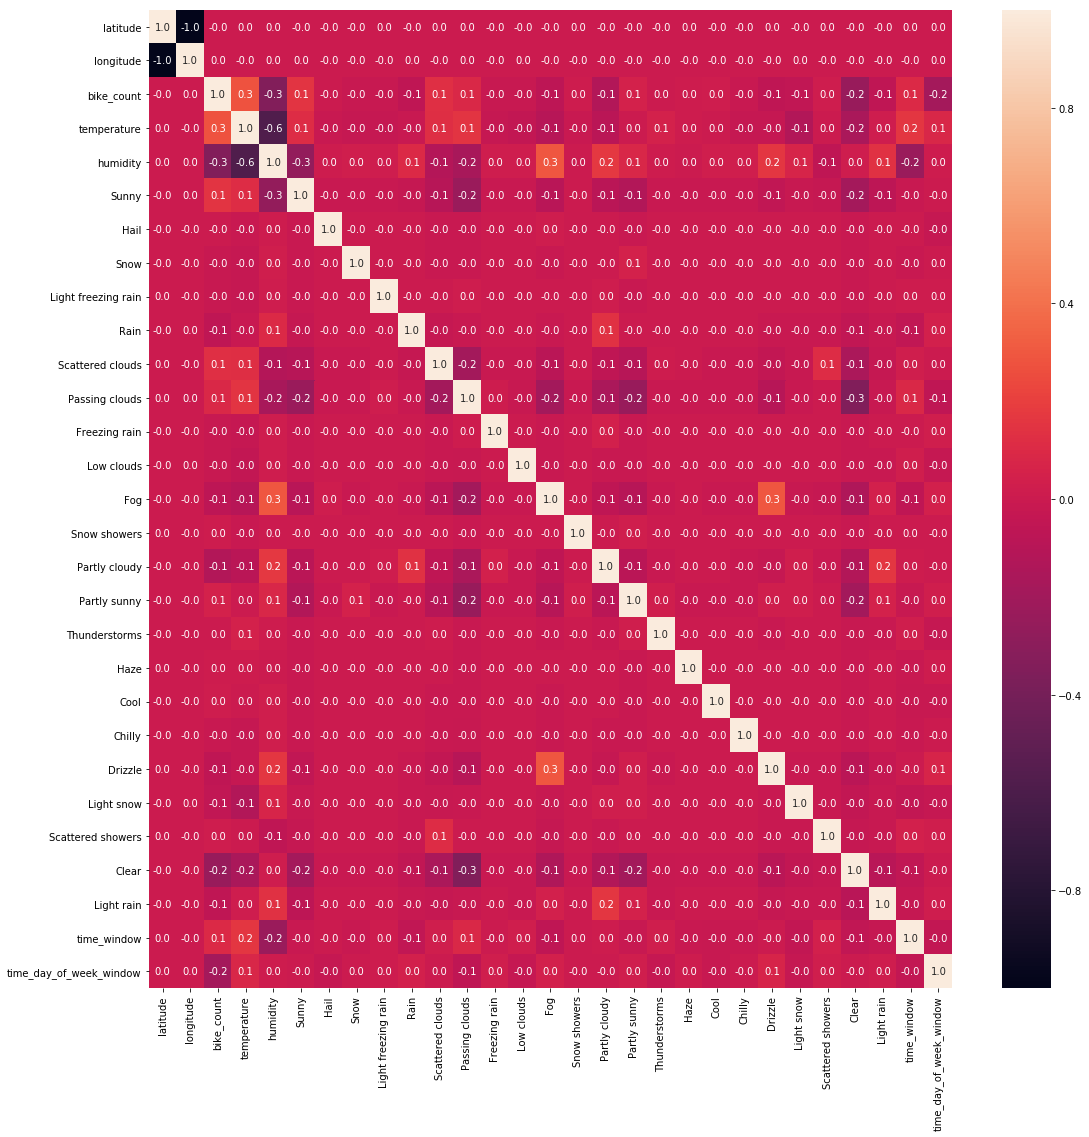

In [12]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(18,18))    

correlation_matrix = df.corr().round(2)
#print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".001f",ax=ax)

# Feature selection

In [6]:
def remove_features(df):
    return df.drop(columns=[        
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
df=remove_features(df)
print(df.shape)

(13403, 30)


# Build models

In [7]:
def build_normal_model():
    #look for regularization with keras 
    initializer = initializers.VarianceScaling(scale=1.0, mode='fan_in', distribution='normal', seed=None)
    model = Sequential()   
    
    model.add(Dense(28, input_dim=28,kernel_initializer='normal', activation='relu'))
    model.add(Dense(14,activation='relu'))    
    model.add(Dense(1, activation='relu'))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae'])
    model.summary()
    return model
normal_model = build_normal_model()
from sklearn.ensemble import RandomForestRegressor
def build_Random_forest_model():
    #model = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
    model = RandomForestRegressor()
    return model
def build_SVM_REGRESSION_model():
    model=SVR()
    return model
def build_XGBOOST_reg_model():
    model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 300)
    return model

#normal_model = build_Random_forest_model()
#normal_model=build_SVM_REGRESSION_model()
#normal_model=build_XGBOOST_reg_model()
model = normal_model

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28)                812       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


# Defining model execution functions

In [8]:
def save_model(dataFrame,model_name,min_value,max_value):
    import pickle
    file_name_string='./data/model_data_prediction/'+model_name+"_predictions"
    if min_value!=None or max_value!=None:
        file_name_string+="_from_"+str(min_value)+"_to_"+str(max_value)
    file_name_string+=".bin"
    print("this is the filename string")
    print("Saving model on "+file_name_string)
   
    dataFrame[min_value:max_value].to_pickle(file_name_string)
def execute_Sequential_model(model,df):
    df.set_index('timestamp_from', inplace=True)
    df = df.sort_values(by=['timestamp_from'])

    #set bike_count as Y
    df_y = df.bike_count
    df_x = df.drop(columns="bike_count")
    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)


    #Prepare train & test dataset
    test_size = 0.2
    total = x_in.shape[0]
    train_idx = round((1-test_size) * total)



    x_train = x_in[0:train_idx].values
    #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

    x_test = x_in[train_idx+1:total-1].values
    #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    y_train = y_in[0:train_idx].values
    y_test = y_in[train_idx+1:total-1]



    print("x_train shape {}".format(x_train.shape))
    print("y_train shape {}".format(y_train.shape))
    def show_loss_graph(hist,variable):
        plt.plot(history.history[variable])    
        plt.title('model '+variable)
        plt.ylabel(variable)
        plt.xlabel('epoch')
        plt.legend(['train '+variable], loc='upper left')
        plt.show()
    history=model.fit(x_train, y_train,epochs=8)

    model.save('./model/model-23-jun.bin')
    show_loss_graph(history,"loss")
    show_loss_graph(history,"mean_squared_error")
    def evaluate_model_and_show_graph(x_test,y_test,model,min_value=None,max_value=None):
        model.evaluate(x_test, y_test)
        y_prediction = model.predict(x_test)
        print(y_prediction)
        y_pred_scaled = y_scaler.inverse_transform(y_prediction)
        y_test_scaled = y_scaler.inverse_transform(y_test)
        mse = mean_squared_error(y_pred_scaled[min_value:max_value], y_test_scaled[min_value:max_value])
        mae=mean_absolute_error(y_pred_scaled[min_value:max_value], y_test_scaled[min_value:max_value])
        print("MSE: "+str(mse))
        print("MAE: "+str(mae))
        plt.rcParams['figure.figsize'] = [18, 18]
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(y_pred_scaled)     
        y_test_df=pd.DataFrame(y_test_scaled)     
        print(pred_df.shape)
        print(type(pred_df.shape))
        
        save_model(pred_df,'FNN',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)  
        
        #y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME   
        l1, = plt.plot(y_test_scaled[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value] ,'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_model_and_show_graph(x_test,y_test,model)
    update_one_hot_data('./data/combined_data_22-jun.tsv','./data/combined_data_22-jun_one_hot_data.tsv')
    df_new_data = pd.read_csv('./data/combined_data_22-jun_one_hot_data.tsv',
                     sep='\t',
                     header=0)
    start_size=df_new_data.shape[0]
    print(df_new_data.shape)
    df_new_data = remove_outlier(df_new_data, "bike_count")
    print("We have removed "+str(start_size-df_new_data.shape[0])+" outliers tuples (which is "+str((start_size-df_new_data.shape[0])/start_size*100)+" % of total).")
    df_new_data=remove_features(df_new_data)    
    df_new_data.set_index('timestamp_from', inplace=True)
    df_new_data = df_new_data.sort_values(by=['timestamp_from'])
    print(df_new_data.shape)


    #set bike_count as Y
    df_y = df_new_data.bike_count
    df_x = df_new_data.drop(columns="bike_count")


    #Normalization
    x = df_x.values
    y = df_y.values.reshape(-1, 1)

    x_scaler = preprocessing.MinMaxScaler()
    x_normalized = x_scaler.fit_transform(x)

    y_scaler = preprocessing.MinMaxScaler()
    y_normalized = y_scaler.fit_transform(y)

    x_in = pd.DataFrame(x_normalized)
    y_in = pd.DataFrame(y_normalized)
    #this line is commented in order to obtain the correct .bin data on data/data_model_prediction
    #evaluate_model_and_show_graph(x_in,y_in,model)
    print("You are running a Sequential model")
    return model
def execute_Random_forest_model(model,df_x,df_y):   
    model.fit(df_x, df_y)
    print("You are running a RandomForest model")
    return model
def execute_SVM_regression_model(model,df_x,df_y):
    model.fit(df_x, df_y)
    print("You are running a SVM-Regression model")
    return model
def execute_XGBOOST_model(model,df_x,df_y):
    model.fit(df_x, df_y)
    print("You are running a XGBOOST model")
    return model
    
    

# Running models

(13403, 30)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
x_train shape (10722, 28)
y_train shape (10722, 1)
Instructions for updating:
Use tf.cast instead.


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/8
10722/10722 [==============================] - 1s 78us/sample - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1661
Epoch 2/8
10722/10722 [==============================] - 1s 47us/sample - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1517
Epoch 3/8
10722/10722 [==============================] - 1s 51us/sample - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1450
Epoch 4/8
10722/10722 [==============================] - 0s 46us/sample - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1405
Epoch 5/8
10722/10722 [==============================] - 0s 43us/sample - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1372
Epoch 6/8
10722/10722 [==============================] - 1s 47us/sample - loss: 0.0341 - mean_squared_error: 0.0341 - mean_absolute_error: 0.1348
Epoch 7/8
10722/10722 [==============================] - 1s 49us/sample - loss: 0.0332 - mean_squared_error: 0.0332 - mean_a

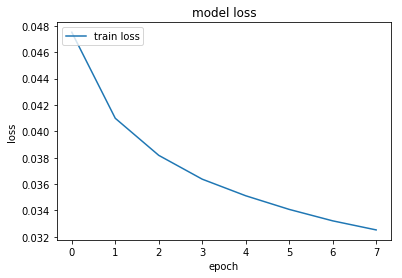

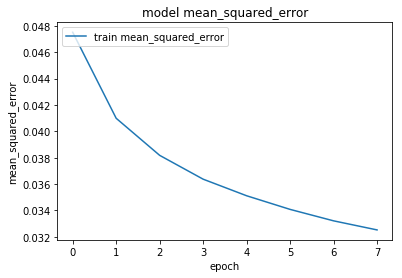

2679/2679 [==============================] - 0s 45us/sample - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1384
[[0.29748768]
 [0.29748768]
 [0.30431876]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
MSE: 31.918940191389932
MAE: 4.012840249815198
(2679, 1)
<class 'tuple'>
this is the filename string
Saving model on ./data/model_data_prediction/FNN_predictions.bin
this is the filename string
Saving model on ./data/model_data_prediction/Ground_t_predictions.bin


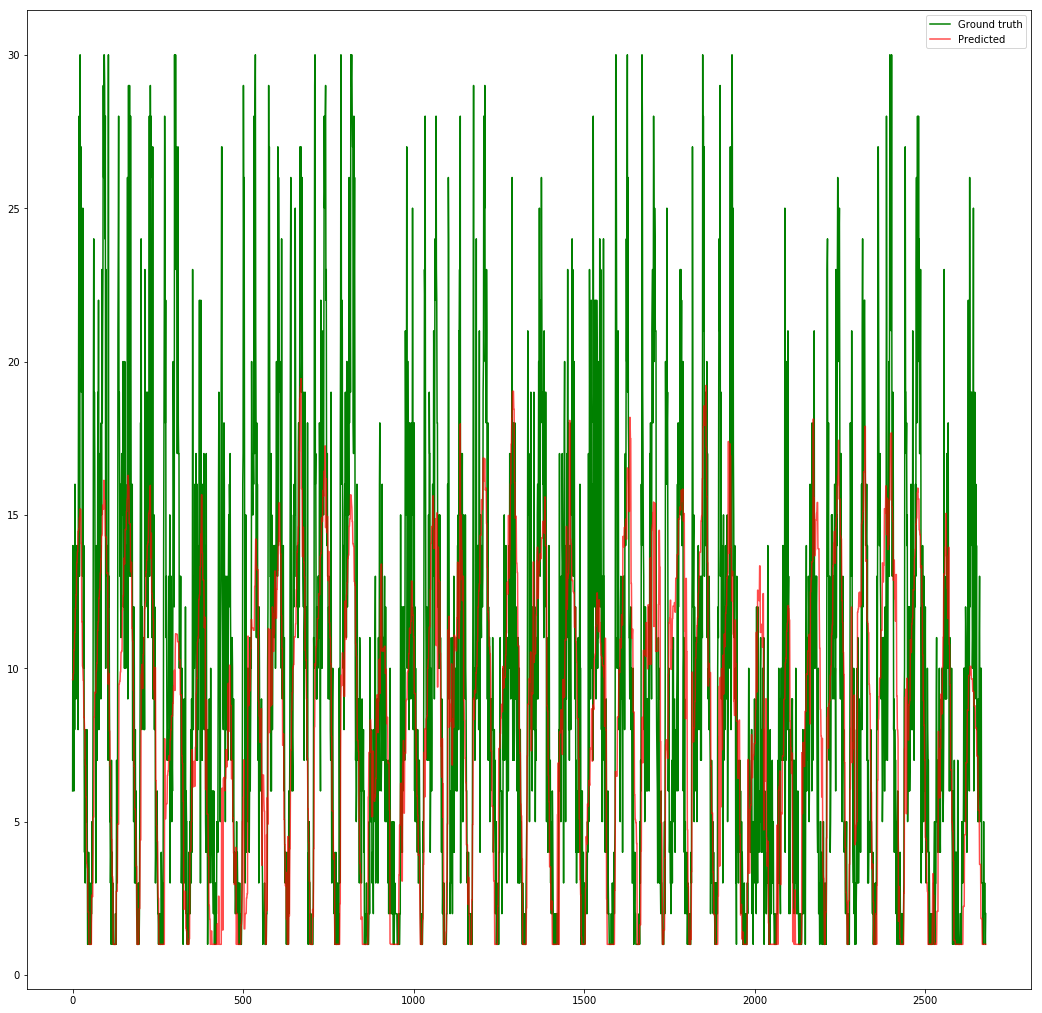

(1451, 48)
We have removed 113 outliers tuples (which is 7.787732598208132 % of total).
(1338, 29)
You are running a Sequential model


/home/luis/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
x_test=None
y_test=None
print(df.shape)
print(type(model))
#input()
def EXECUTE_MODEL(model,df):
    if isinstance(model,sklearn.ensemble.forest.RandomForestRegressor):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        global x_test
        global y_test

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]
        return execute_Random_forest_model(model,x_train,y_train)
    if isinstance(model,sklearn.svm.classes.SVR):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
             

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]        
        return execute_SVM_regression_model(model,x_train,y_train)
    if isinstance(model,xgboost.sklearn.XGBRegressor):
        df.set_index('timestamp_from', inplace=True)
        df = df.sort_values(by=['timestamp_from'])
        #set bike_count as Y
        df_y = df.bike_count
        df_x = df.drop(columns="bike_count")
        #Prepare train & test dataset
        test_size = 0.2
        total = df_x.shape[0]
        train_idx = round((1-test_size) * total)



        x_train = df_x[0:train_idx].values
        #x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        

        x_test = df_x[train_idx+1:total-1].values
        #x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

        y_train = df_y[0:train_idx].values
        y_test = df_y[train_idx+1:total-1]
        return execute_XGBOOST_model(model,x_train,y_train)        
    else:
        return execute_Sequential_model(model,df)
    
    
#print(type(model))
model=EXECUTE_MODEL(model,df)

# Feature Importances 

In [10]:
if isinstance(model,sklearn.ensemble.forest.RandomForestRegressor):
    #print(model.feature_importances_)
    feature_list = list(df.drop(columns="bike_count").columns)
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    #print((model.feature_importances_.shape))
    def evaluate_random_forest_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        #print(predictions)
        # Calculate the absolute errors
        errors = abs(predictions - y_test)
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")  
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(predictions)  
        '''print(type(pred_df))
        print(pred_df.shape)
        print(pred_df)
        input()'''
        save_model(pred_df,'RandomForestRegressor',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)     
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME  
        
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_random_forest_model(x_test,y_test)
if isinstance(model,sklearn.svm.classes.SVR):
    #print(model.feature_importances_)
    
    #print((model.feature_importances_.shape))
    def evaluate_random_SVM_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        #print(predictions)
        # Calculate the absolute errors
        errors = abs(predictions - y_test)
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")  
        #---SAVING PREDICTIONS DATAFRAME
        pred_df=pd.DataFrame(predictions)      
        save_model(pred_df,'SVR',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)  
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME        
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()
    evaluate_random_SVM_model(x_test,y_test)
if isinstance(model,xgboost.sklearn.XGBRegressor):
    def evaluate_xgboost_model(x_test,y_test,min_value=None,max_value=None):
        
        predictions = model.predict(x_test)
        print(type(predictions))
        
        #print(predictions)
        # Calculate the absolute errors
        errors = abs(predictions[min_value:max_value] - y_test[min_value:max_value])
        #print(errors.shape)
        #print('Mean Absolute Error:', round(numpy.mean(errors), 2), 'bikes.')
        mse = mean_squared_error(predictions[min_value:max_value], y_test[min_value:max_value])
        mae=mean_absolute_error(predictions[min_value:max_value], y_test[min_value:max_value])
        print("MSE",mse)
        print("MAE",mae)
        plt.rcParams['figure.figsize'] = [18, 18]        
        temp_df=y_test.reset_index(inplace=False)
        temp_df=temp_df.drop(columns="timestamp_from")         
        #---SAVING PREDICTIONS DATAFRAME
        
        pred_df=pd.DataFrame(predictions) 
        print(pred_df)
        print(type(pred_df))
        
        save_model(pred_df,'XGBRegressor',min_value,max_value)
        y_test_df=y_test.reset_index(inplace=False)   
        y_test_df=y_test_df.drop(columns="timestamp_from")
        save_model(y_test_df,'Ground_t',min_value,max_value)
        #---END SAVING PREDICTIONS DATAFRAME
        l1, = plt.plot(temp_df[min_value:max_value], 'g')
        l2, = plt.plot(pred_df[min_value:max_value], 'r', alpha=0.7)
        plt.legend(['Ground truth', 'Predicted'])
        plt.show()    
    evaluate_xgboost_model(x_test,y_test)
   

In [11]:
 print(dt.now()-start)

0:00:55.111504
